In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [54]:

conn = sqlite3.connect('../db.sqlite3')
query = (r'''
SELECT *
FROM restaurant_order
JOIN restaurant_orderitem ON restaurant_order.id = restaurant_orderitem.order_id
JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id;
''')
df = pd.read_sql_query(query, conn)
df.head()

,id,datetime,quantity,order_id,product_id,price,name
0,6,2019-08-03 20:25:00,2,1,6,0.80,Plain Papadum
1,240,2019-08-03 20:25:00,1,1,240,12.95,King Prawn Balti
2,19,2019-08-03 20:25:00,1,1,19,2.95,Garlic Naan
3,36,2019-08-03 20:25:00,1,1,36,3.95,Mushroom Rice
4,111,2019-08-03 20:25:00,1,1,111,8.95,Paneer Tikka Masala


In [55]:
df = df.drop(["product_id"], axis=1)

In [56]:

# Save the results to a CSV file
df.to_csv("restataraunt_data.csv", index=False)
df.head()

,id,datetime,quantity,order_id,price,name
0,6,2019-08-03 20:25:00,2,1,0.80,Plain Papadum
1,240,2019-08-03 20:25:00,1,1,12.95,King Prawn Balti
2,19,2019-08-03 20:25:00,1,1,2.95,Garlic Naan
3,36,2019-08-03 20:25:00,1,1,3.95,Mushroom Rice
4,111,2019-08-03 20:25:00,1,1,8.95,Paneer Tikka Masala


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

In [78]:
top_ten=df.groupby("name")["quantity"].sum().reset_index().sort_values(by="quantity",ascending=False).head(10)

In [79]:
top_ten.head(10)

,name,quantity
188,Plain Papadum,10648
186,Pilau Rice,6367
187,Plain Naan,4983
81,Garlic Naan,3318
189,Plain Rice,2964
165,Onion Bhajee,2749
144,Mango Chutney,2504
52,Chicken Tikka Masala,2473
26,Chapati,1935
153,Mint Sauce,1840


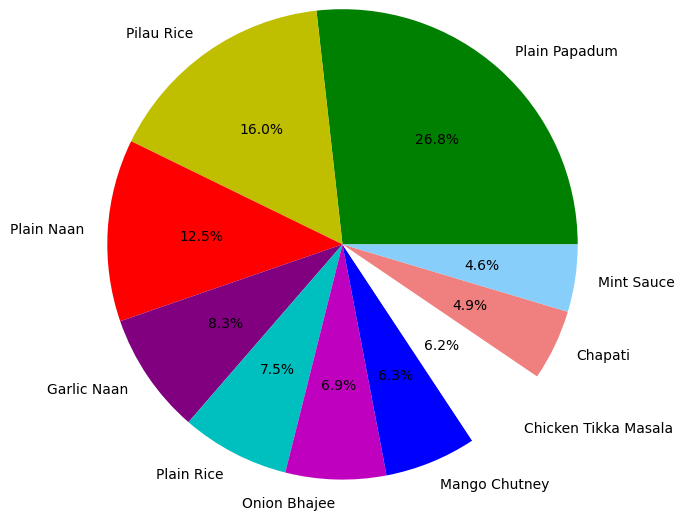

In [80]:
colors = ["g", "y", "r", "purple", "c", "m", "b", "w", "lightcoral", "lightskyblue"]


plt.pie(x=top_ten["quantity"], labels=top_ten["name"],colors=colors, autopct='%1.1f%%', radius=3)
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

In [83]:
df["item-price"] = df["price"] * df["quantity"]

In [90]:
top_money=df.groupby("name")["item-price"].sum().reset_index().sort_values(by="item-price",ascending=False).head(10)


In [91]:
top_money.head(5)

,name,item-price
52,Chicken Tikka Masala,22133.35
186,Pilau Rice,18782.65
187,Plain Naan,12955.80
97,Korma,12261.50
16,Bombay Aloo,10894.45


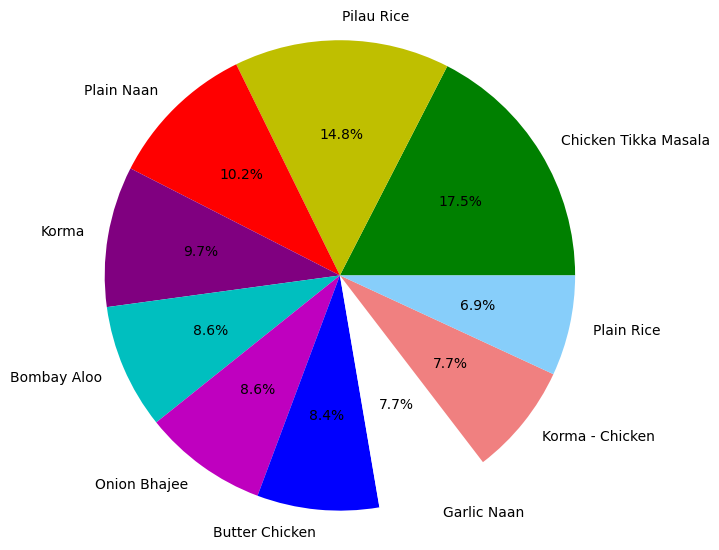

In [94]:
colors = ["g", "y", "r", "purple", "c", "m", "b", "w", "lightcoral", "lightskyblue"]


plt.pie(x=top_money["item-price"], labels=top_money["name"],colors=colors, autopct="%1.1f%%", radius=3)
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

In [100]:
df["order-hour"]=pd.to_datetime(df["datetime"]).apply(lambda x: x.hour)

In [114]:
hour_income=df.groupby("order-hour")["item-price"].sum().reset_index().sort_values(by="item-price", ascending=False).head(12)

In [115]:
hour_income.head(23)

,order-hour,item-price
17,18,132462.50
18,19,109045.05
16,17,72110.20
19,20,50218.25
20,21,21480.30
15,16,15634.75
21,22,11001.50
11,12,10565.85
12,13,8282.65
10,11,3807.05


<Axes: >

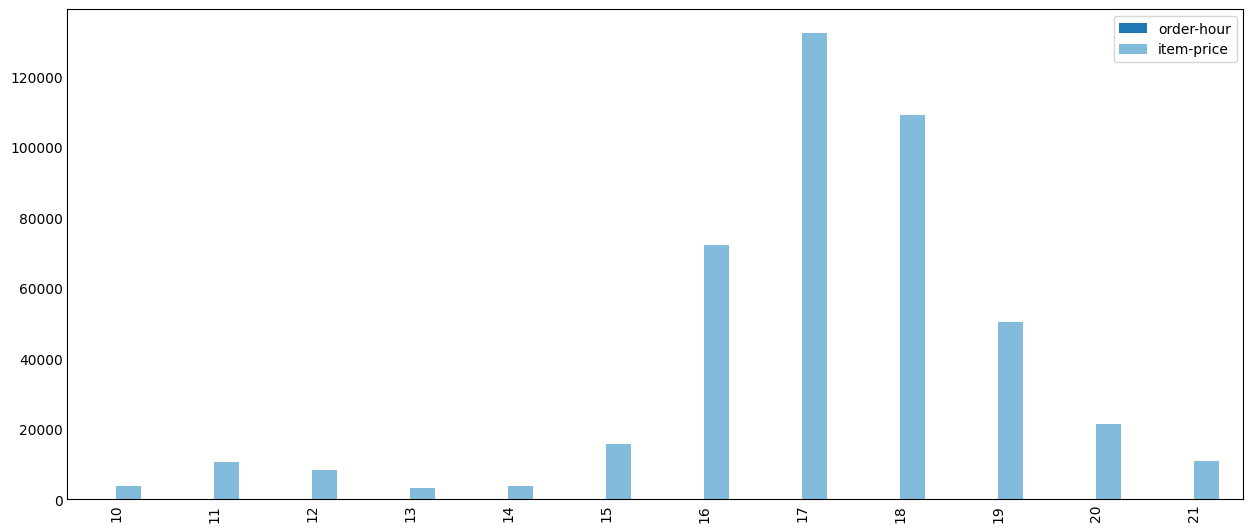

In [117]:
hour_income.sort_values(by="order-hour").plot(kind="bar", figsize=(12,5))

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

In [136]:
df["order-day"]=pd.to_datetime(df["datetime"]).apply(lambda x: x.day_name())

In [144]:
day_income=df.groupby("order-day")["item-price"].sum().reset_index()

In [145]:
day_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order-day   7 non-null      object 
 1   item-price  7 non-null      float64
dtypes: float64(1), object(1)
memory usage: 240.0+ bytes


<BarContainer object of 7 artists>

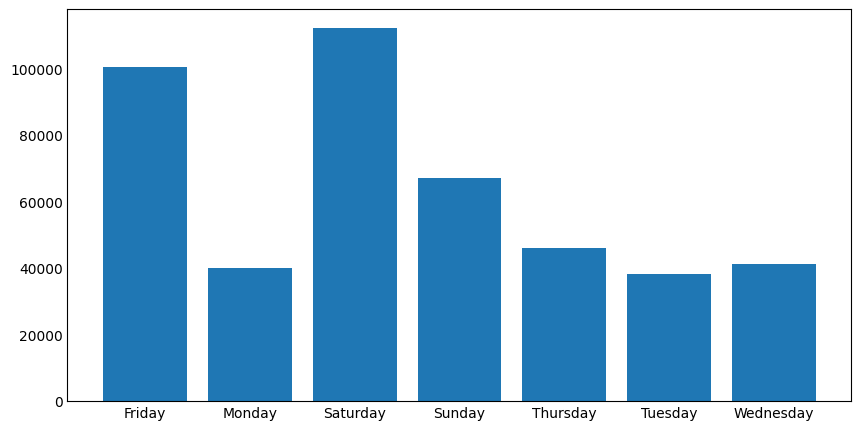

In [146]:
plt.figure(figsize=(8,4))
plt.bar(x=day_income["order-day"],height=day_income["item-price"])
